<a href="https://colab.research.google.com/github/ttourneux/Final-Project/blob/main/Final_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS480E/580E: Final Exam





## General Instructions 
### Due December 14th, 11:59 PM.

In the final exam, you will use autoencoders to do dimensionality reduction on the MNIST images. You will then use the reduced dimensional representations to perform similarity search on test images. At the end of notebook, you will be able to retrieve k-most similar images on the training set.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section. 

Make sure to **run** the cells marked for running to make sure all the data and functions are available. 


In [3]:
import math
import random
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

%matplotlib inline

from tqdm import tqdm


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Dataset
 
You will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). 

To simplify our code here, use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Run** the following cell to mount your drive on colab.

In [5]:
'''# Mount the drive
from google.colab import drive
drive.mount('/content/drive')'''

"# Mount the drive\nfrom google.colab import drive\ndrive.mount('/content/drive')"

**Run** the following cells to retrieve the MNIST training, validation, and test sets

In [6]:
mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())

mnist_test = dset.MNIST('./MNIST_data', train=False, download=True,
                        transform=T.ToTensor())

mnist_train, mnist_validation = random_split(mnist_train, [.8, .2])

**Run** this cell to print the number of cells on the traning, validation, and test datasets. 

In [7]:
print(len(mnist_train), len(mnist_validation), len(mnist_test))

48000 12000 10000


**Run** this cell to define the helper function to generate grids of images. 

In [8]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

**Implement** the following cell to define a `batch_size`, `loader_train`, and `loader_validation`. 

`batch_size` should be an integer value that defines the number of samples per mini-batch that will be used for the training dataloader. 

`loader_train` should be a PyTorch DataLoader on the `mnist_train` dataset with `batch_size = batch_size`, `shuffle` enabled and drop the last mini-batch. 

`loader_validation` should be a PyTorch DataLoader on the `mnist_validation` dataset. Set the `batch_size` as high as possible for this. 

In [58]:
# ==== BEGIN SOLUTION CODE ====
batch_size = 128
num_workers = 6

loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle = True, 
                          drop_last = True, num_workers=num_workers, persistent_workers= True)#
## set batch_size as high as possible for this : batch_size =len(mnist_validation)
loader_validation = DataLoader(mnist_validation, batch_size = len(mnist_validation) , shuffle = True,
                               drop_last= True, num_workers= num_workers,persistent_workers= True)
                               
                    


# ==== BEGIN SOLUTION CODE ====

**Run** the following cell to show an example of a grid of MNIST images.

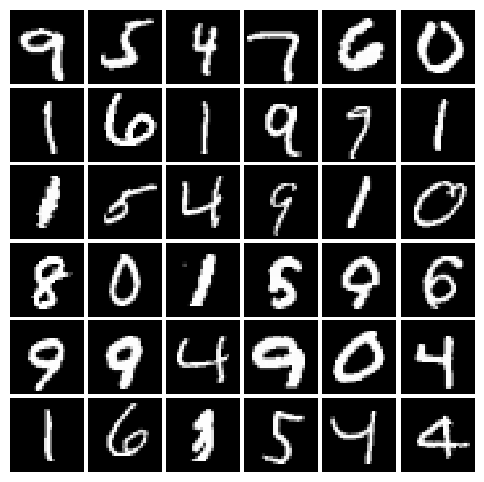

In [10]:
imgs = next(iter(loader_train))[0].view(batch_size, 784)
show_images(imgs[:36])

# (Part 1) Autoencoder - 60 pts

In the next cell, **implement** the definition of the `AutoEncoder` class, that implements an autoencoder using convolutions, transpose convolutions, fully connected and non-linear activation layers. 



You are free to choose any architecture you would like. 
**But your network must use at least 1 convolution layer**


Complete the following methods:

- `__init__(height, width, latent_dim)`: Initializes the desired layer and architecture.
  - The inputs to the class constructor are: 
    - `height`: The height of the input images
    - `width`: The width of the input images
    - `latent_dim`: The size of the latent vector
- `encode(x)`: Encodes a batch of images `x` to a batch of latent vectors, `h`
- `decode(h)`: Decodes a batch of latent vectors `h` to a batch images, `x_reconstructed` 
- `forward(x)`: Uses `encode` and `decode` method to compress and reconstruct a batch of images, `x`. 

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super().__init__()

        # ==== BEGIN SOLUTION CODE ====   
        self.input_size = input_size 
        self.hidden_dim = hidden_dim  

        self.conv1 = nn.Conv2d(1,32,3,padding=1)## should keep the same shape of 28*28
        self.conv2 = nn.Conv2d(32,64,3, padding= 1 )   

        self.flatten = nn.Flatten()

        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(64*784,self.hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)

        self.encoder = nn.Sequential(
            self.conv1, 
            self.conv2,
            self.flatten,
            self.fc1,self.ReLU,
            self.fc2, self.ReLU,
            self.fc3, self.ReLU
        )
        # ==== END SOLUTION CODE ====

    def forward(self, x):
        '''
        Use the self._encoder to encode the image to the hidden dimension
        
        Inputs:
        - x: Tensor of shape (N, 1, H, W ) where H * W = input_size

        Returns:
        - h: Tensor of shape (N , hidden_dim)
        '''
        # ==== BEGIN SOLUTION CODE ====
        '''x = self.flatten(x)
        x = self.fc1(x)
        x = self.ReLU(x) 
        x = self.fc2(x) 
        x = self.ReLU(x) 
        x = self.fc3(x) 
        h = x '''
        h = self.encoder(x)

        # ==== END SOLUTION CODE ====
        return h

In [27]:
## sanity check for encoder. 
## Dim should be (32,96) and it is. 

encoder = Encoder(786,96)
rtensor = torch.rand((32,1,28,28))

ans = encoder.forward(rtensor)
ans.shape 

torch.Size([32, 96])

In [32]:
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_dim, height=28, width=28):
        super().__init__()
        self._decoder = None
        self.latent_size = latent_size
        self.hidden_dim = hidden_dim
        self.height = height
        self.width = width
        self.output_size = height * width

        # ==== BEGIN SOLUTION CODE ====
        self.ReLU = nn.ReLU()
        
        self.fc1 = nn.Linear(self.latent_size,self.hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc4 = nn.Linear(hidden_dim, self.output_size*64)

        self.sigmoid = nn.Sigmoid()

        self.unflatten = nn.Unflatten(1, (64,self.width,self.height))## we should unflatten to have channels of 64
        self.convT1 = nn.ConvTranspose2d(64,32,3,padding = 1)
        self.convT2 = nn.ConvTranspose2d(32,1,3,padding= 1 )
        '''        self.encoder = nn.Sequential(
            self.conv1, 
            self.conv2,
            self.flatten,
            self.fc1,self.ReLU,
            self.fc2, self.ReLU,
            self.fc3, self.ReLU
        )'''

        self.decoder = nn.Sequential(
            self.fc1,self.ReLU,

            self.fc2,self.ReLU,

            self.fc3,self.ReLU,

            self.fc4,self.ReLU,

            self.unflatten,
            
            self.convT1, 
            self.convT2,
            self.sigmoid,## need to do sigmoid at the end so BCE will get a value between 0 and 1 
        )



        # ==== END SOLUTION CODE ====


    def forward(self, z):
        """
        Use the self._decoder to reconstruct the image
        
        Inputs:
        - Z: Tensor of shape (N, Z) giving the latent vector

        Returns:
        - x_reconstructed: Reconstruced input data of shape (N,1,H,W)
          whete, H is self.height, and W is self.width
        """
        x_reconstructed = None

        # ==== BEGIN SOLUTION CODE ====
        '''
        x = self.fc1(z)
        x = self.ReLU(x) 


        x = self.fc2(x) 
        x = self.ReLU(x)

        x = self.fc3(x) 
        x = self.ReLU(x)

        x = self.fc4(x) 
        x = self.sigmoid(x) 

        x_reconstructed = self.unflatten(x)'''
        x_reconstructed = self.decoder(z)


        # ==== END SOLUTION CODE ====
        return x_reconstructed    


In [33]:
## sanity check for decoder 
## should output (16,1,28,28) and it does.

        

decoder = Decoder(32,96)
rtensor = torch.rand((16,32))

ans = decoder.forward(rtensor)
ans.shape

torch.Size([16, 1, 28, 28])

In [15]:
def reparameterize(mu, logvar):
    N,Z = mu.shape
    epsilon = torch.normal(torch.zeros((N,Z)),torch.ones(N,Z)).to(device)
    sigma = torch.exp(logvar).to(device)

    mu = mu.to(device)

    z = sigma*epsilon + mu
    assert(z.shape == (N,Z))
    # ==== END SOLUTION CODE ====
    
    return z

In [35]:
## we can just use the VAE defined in hw4.

class AutoEncoder(nn.Module):
    def __init__(self, height, width, latent_dim):
        """
        """
        super().__init__()

        # ==== BEGIN SOLUTION CODE ====
        self.height = height 
        self.width = width
        self.latent_dim = latent_dim
        
        self.hidden_dim = 96## not passed as a parameter when model is called 

        self.encoder = Encoder(self.height*self.width,hidden_dim=self.hidden_dim)
        self.decoder = Decoder(self.latent_dim, hidden_dim=self.hidden_dim)

        ## defined in HW4
        self.mu_layer =nn.Linear(self.hidden_dim,self.latent_dim)
        self.logvar_layer = nn.Linear(self.hidden_dim,self.latent_dim)
        
        
        # ==== END SOLUTION CODE ====
    def encode(self, x):
        """
        """
        h = None
        # ==== BEGIN SOLUTION CODE ====
        hd_vector = self.encoder(x)
        
        self.mu = self.mu_layer(hd_vector)
        self.logvar = self.logvar_layer(hd_vector)

        h = reparameterize(self.mu, self.logvar)


        # ==== END SOLUTION CODE ====
        return h ## h is the latent vector (previously called z )

    def decode(self, h):
        """
        """
        x_reconstructed = None
        # ==== BEGIN SOLUTION CODE ====
        x_reconstructed = self.decoder(h)
        # ==== END SOLUTION CODE ====
        return x_reconstructed 
    
    def forward(self, x):
        """
        """
        ## keep in mind that we need my and logvar for the loss
        ## we also will be using the latent vector Z to group the images which is really 
          ## z = reparameterize (mu, logvar) 

        x_reconstructed = None
        # ==== BEGIN SOLUTION CODE ====
        h = self.encode(x)

        x_reconstructed = self.decode(h)
        
        # ==== END SOLUTION CODE ====
        return x_reconstructed, self.mu, self.logvar
        ##return x_reconstructed

In [17]:
0<float('nan')

False

In [44]:
#VAE_Loss(x_train_batch, x_hat, mu, logvar)
def VAE_Loss(x, x_reconstructed, mu, logvar):
  loss = None
  # ==== BEGIN SOLUTION CODE ====
  #print('mu',mu,mu.shape)
  #print('logvar', logvar,mu.shape)
  N,Z = mu.shape
  #print("N",N)## this is 128 the batch size
  assert(torch.all(torch.isfinite(x_reconstructed)))
  
  assert(torch.all(torch.isfinite(x)))

  #print(x_reconstructed[0])
  assert(torch.all(x_reconstructed<=1))
  assert(torch.all(x_reconstructed>=0))

  assert(torch.all(x<=1))
  assert(torch.all(x>=0))

  #assert()
  #print('x_reconstructed',x_reconstructed)
  #print('x',x)
  reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed,x, reduction='sum')## using mean 
  reconstruction_loss = reconstruction_loss/int(N)
  
  #print('completed reconstruction_loss') ## it is the reconstruction loss that is throwing the error


  D_KL = -.5*torch.sum(1 + logvar - mu**2 -torch.exp(logvar)) 
  D_KL_loss = D_KL/int(N) ## this will average over all samples
  #print('completed D_KL_loss')
  #print('loss:',(D_KL_loss + reconstruction_loss)/2)
  return (D_KL_loss + reconstruction_loss)/2## the mean of these two losses

In [42]:
'''def VAE_Loss(x, x_reconstructed, mu, logvar):
  loss = None
  # ==== BEGIN SOLUTION CODE ====
  #print('mu',mu,mu.shape)
  #print('logvar', logvar,mu.shape)
  N,Z = mu.shape
  #print("N",N)## this is 128 the batch size
  assert(torch.all(torch.isfinite(x_reconstructed)))
  
  assert(torch.all(torch.isfinite(x)))
  reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed,x, reduction='sum')## using mean 
  reconstruction_loss = reconstruction_loss/int(N)
  
  #print('completed reconstruction_loss') ## it is the reconstruction loss that is throwing the error


  D_KL = -.5*torch.sum(1 + logvar - mu**2 -torch.exp(logvar)) 
  D_KL_loss = D_KL/int(N) ## this will average over all samples
  #print('completed D_KL_loss')
  return (D_KL_loss + reconstruction_loss)#/2## the mean of these two losses'''

'def VAE_Loss(x, x_reconstructed, mu, logvar):\n  loss = None\n  # ==== BEGIN SOLUTION CODE ====\n  #print(\'mu\',mu,mu.shape)\n  #print(\'logvar\', logvar,mu.shape)\n  N,Z = mu.shape\n  #print("N",N)## this is 128 the batch size\n  assert(torch.all(torch.isfinite(x_reconstructed)))\n  \n  assert(torch.all(torch.isfinite(x)))\n  reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed,x, reduction=\'sum\')## using mean \n  reconstruction_loss = reconstruction_loss/int(N)\n  \n  #print(\'completed reconstruction_loss\') ## it is the reconstruction loss that is throwing the error\n\n\n  D_KL = -.5*torch.sum(1 + logvar - mu**2 -torch.exp(logvar)) \n  D_KL_loss = D_KL/int(N) ## this will average over all samples\n  #print(\'completed D_KL_loss\')\n  return (D_KL_loss + reconstruction_loss)#/2## the mean of these two losses'

## Autoencoder Training

In the following cell, define an autoencoder (AE) and train on the training set. 

The AE training algorithm is as follows:

1. Instantiate an `AutoEncoder` 
2. Define an optimizer for your AE
3. For each batch of data in `loader_train`:
    - Pass the input through the AE to get the reconstructed input, the mean and log-var approximate of the posterior
    - Calculate the loss using the [`nn.functional.binary_cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) 
    - Zero the gradients, propagate the loss backwards, and update the  weights using the optimizer

4. Repeat 3
5. After N iterations (or every epoch), compute the validation loss over the validation set (using the `loader_validation`). 


In [62]:
model = AutoEncoder(28,28,16) # Instantiate your model to this variable
model.to(device)


# ==== BEGIN SOLUTION CODE ====
EPOCHS = 50## we should time this 
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

loss_stats = []

#------------------
for  epoch in tqdm(range(1,EPOCHS+1), disable = 0):
  train_epoch_loss = 0 
  model.train()
  for x_train_batch, y_train_batch in tqdm(loader_train, disable = 1):
    #print()
    #print('batch')

    x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
    optimizer.zero_grad()

    x_hat, mu, logvar = model(x_train_batch.float())
    train_loss = VAE_Loss(x_train_batch, x_hat, mu, logvar)

    train_loss.backward()
    optimizer.step()

    train_epoch_loss+=train_loss

  loss_stats.append(train_epoch_loss)


# ==== END SOLUTION CODE ====
## DataLoader stats: 

## with 2 workers :
## with persistent workers, at 10 epoches we have 5.91 seconds per epoch
## without persistent workers, at 10 epoches we have 9.65


## with 6 workers:
## without persistent workers, we have lots of down time! 
## with persistent workers, at 10 epochs we have 6.05 seconds per epoch.  

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:00<00:00,  6.02s/it]


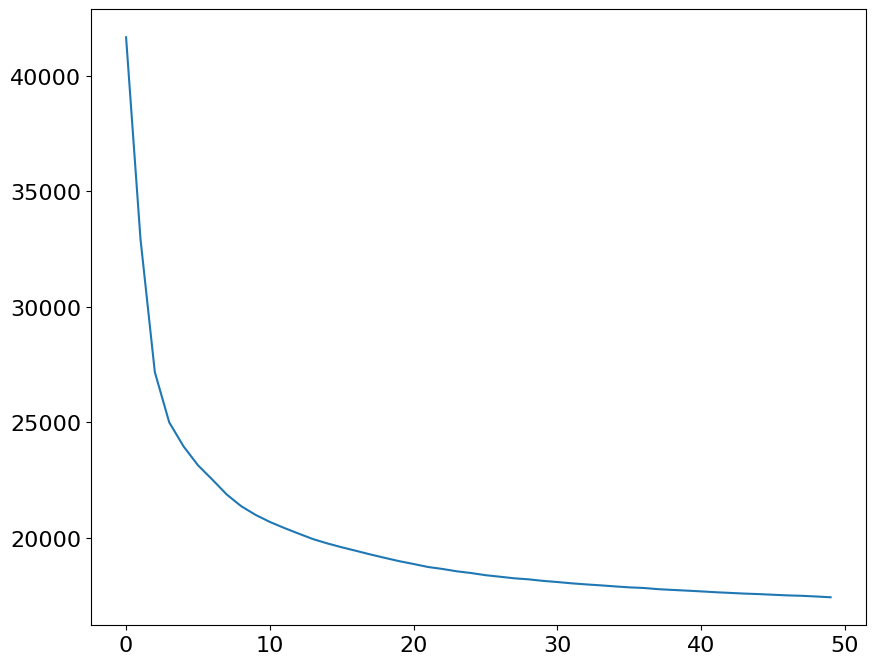

In [63]:
cpu_loss_stats =[]
for i in loss_stats: 
  cpu_loss_stats.append(i.to('cpu').detach().numpy())

plt.plot(cpu_loss_stats)

**Implement** the following cell to generate 36 random reconstructions from your previously trained AE model and visualize the outputs. 

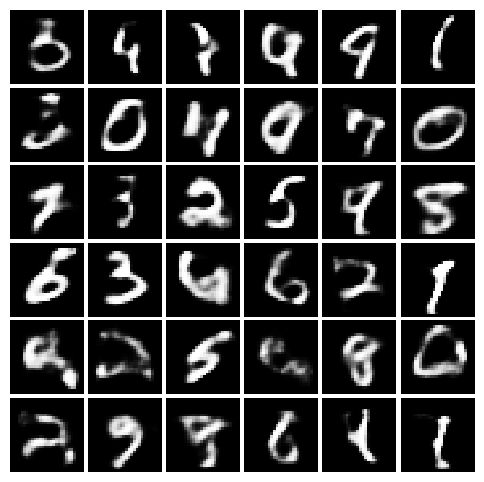

In [64]:
# ==== BEGIN SOLUTION CODE ====
latent_size =16

random_z = torch.normal(0,1,size =(36,latent_size)).to(device)## doesn't make a difference
trained_decoder = model.decoder
trained_decoder.eval()

imgs = trained_decoder(random_z)
show_images(imgs.cpu().detach())
# ==== END SOLUTION CODE ====

# (Part 2) Similarity Search

Now using your trained model, you will generate latent vectors of the training images. This will encode the images into a vector. 

You will also use your trained models to encode a test image into a vector, compute a similarity measure ($L_2$ or Cosine-similarity) with the training latent vectors. 

**Implement** the following cell to complete the `generate_latent_vectors` function. 

The arguments are:

- `model`: The model used to generate the latent encodings
- `dataset`: The dataset to the generate the latent encodings 

Returns:
- PyTorch tensor of latent vectors computed from the dataset images using the model. It should be a 2D tensor with `len(dataset)` rows and `latent_dim` columns. 

Iterate over each image in the `dataset` and `encode` the images using the `model`. Make sure to turn off backprop and gradient calculations using `with torch.no_grad()` and set the model to evaluation mode using `model.eval()`. 

You may find the `torch.vstack` function useful.

In [103]:
def generate_latent_vectors(model, dataset):
    '''
    Iterates over the dataset and uses the model to generates latent vectors.
    Returns a Torch tensor of latent vectors of shape 

    Args:
      - model : trained model
      - dataset: PyTorch dataset of images
    
    Returns:
      - latent_vectors - Torch tensor of dimension (len(dataset), latent_dim). 
    '''
    latent_vectors = None
    # ==== BEGIN SOLUTION CODE ====
    encoder = model.encoder
    encoder.eval()
    #print(encoder)
    #latent_vectors = torch.tensor([]).to(device)
    with torch.no_grad(): 
      for i in tqdm(range(len(dataset))):
        #print(dataset[i][0], dataset[i][0].shape)
        z = encoder(dataset[i][0].reshape((1,1,28,28)).to(device))
        if latent_vectors == None:
          latent_vectors = z 
        else : 
          latent_vectors = torch.cat((latent_vectors,z))




    #assert(tuple(latent_vectors.shape)==(len(dataset),latent_size))


    # ==== END SOLUTION CODE ====
    return latent_vectors

**Run** the following cell to generate the latent vectors of the images from the `mnist_train` dataset using your `model` and the `generate_latent_vectors` dataset. 

In [104]:
training_vectors = generate_latent_vectors(model, mnist_train)

100%|███████████████████████████████████████████████████████████████████████████| 48000/48000 [00:58<00:00, 813.69it/s]


**Implement** the `cosine_sim` function that computes the cosine similarity between each row of input tensors `a` and `b` and the 1-D tensor of indices with the of the `k` closest values. 


*Hint: You can use the [torch.nn.functional.cosine_similarity](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html#torch.nn.functional.cosine_similarity) and 
[torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) functions. Make sure you use the appropriate parameters*  

In [129]:
def cosine_sim(a, b, k=5):
    # ==== BEGIN SOLUTION CODE ====
    sim=nn.functional.cosine_similarity(a,b, dim = 1 )## largest values are most similar 
    topk = torch.topk(sim,k)
    #print(sim)
    return topk
    # ==== END SOLUTION CODE ====

**Implement** the `l2_pairwise_dist` function that computes the cosine similarity between each row of input tensors `a` and `b` and returns the 1-D tensor of indices with the of the `k` closest values. 

*Hint: You can use the [torch.nn.functional.pairwise_distance](https://pytorch.org/docs/stable/generated/torch.nn.functional.pairwise_distance.html#torch.nn.functional.pairwise_distance) and 
[torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) functions. Make sure you use the appropriate parameters*

In [136]:
def l2_pairwise_dist(a, b, k=5):
    # ==== BEGIN SOLUTION CODE ====
    dist= nn.functional.pairwise_distance(a,b)## smallest values are most similar 
    topk = torch.topk(dist, k,largest = False)
    

    return topk 
    # ==== END SOLUTION CODE ====

In [161]:
input1 = torch.randn(1);input1
input2 = torch.randn(5,7)
TK= l2_pairwise_dist(input1, input2,3)
TK[1]

tensor([3, 2, 0])

**Implement** the following function to find the top-k most similar images for a given image using a given 2-D array of latent vectors. 

The arguments are:
    - `img`: The image to search similar images for.
    - `model`: The trained model to use to generate latent vector of `img`.
    - `latents`: The 2D tensor of latent vectors of the training dataset. Find the similar vectors to `img`s latent vector within this 2D tensor. 
    - `k`: The number of indices to return (default: 5)
    - `distance_function`: The distance function to use to measure the similarity between latent vectors.  
  

Returns:
    - The 1-D tensor of indices of the similar images to `img`


Get the latent vector of `img` using your `model`s `encode` and then use the `distance_function` to get the `k`-nearest vectors. 

In [166]:
def find_top_k(img, model, latents, k = 5, distance_function=cosine_sim):
    ind = None
    # ==== BEGIN SOLUTION CODE ====
    encoder = model.encoder
    z = encoder(img.reshape(1,1,28,28).to(device))
    dist = distance_function(z,latents,k)#.indicies
    ind = dist[1]#.indices
    
    # ==== END SOLUTION CODE ====
    return ind

**Run** the following cell to define the top-k image visualization helper function. 

In [164]:
def show_top_k_images(root_image, images):

    num_images = len(images) + 1
    sqrtimg = int(math.ceil(math.sqrt(28)))

    fig = plt.figure(figsize=(num_images*2.5, num_images*5))
    gs = gridspec.GridSpec(1, num_images)
    gs.update(wspace=0.05, hspace=0.05)
    images = [root_image] + images

    for i, img in enumerate(images):
        
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([28, 28]))
        if i == 0:
            ax.set_title("Search Image")
    return

**Run** the following cell to get the 5 most similar images to an image from the test set using a cosine similarity metric.

If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar. 

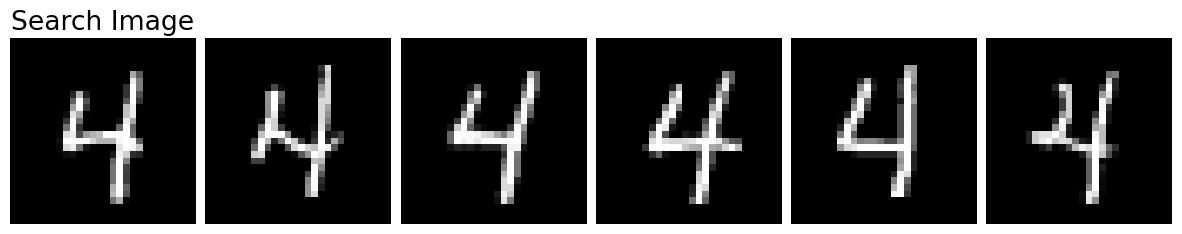

In [167]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, model, training_vectors, k=5, distance_function= cosine_sim)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)

**Run** the following cell to get the 5 most similar images to an image from the test set using a $\mathcal{l}_2$ distance.


If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar. 

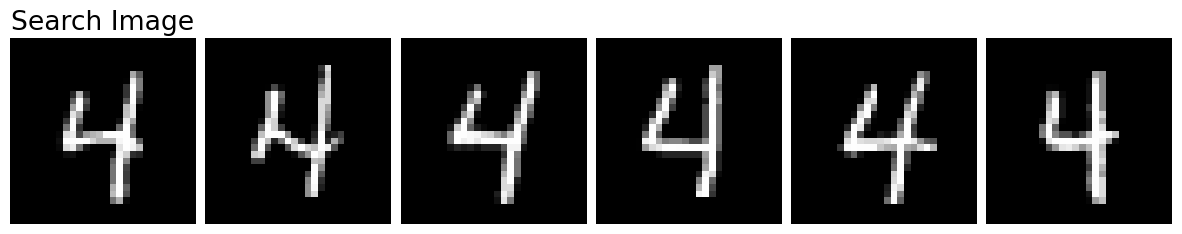

In [168]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, model, training_vectors, k=5, distance_function=l2_pairwise_dist)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)